<a href="https://colab.research.google.com/github/Will170393/MSc-Project---Stance-Detection/blob/master/5_msc_project_lstm_glove.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# libraries for processing data
import numpy as np
import pandas as pd
import re

# libraries for loading files from drive
from google.colab import drive
drive.mount('/content/gdrive')

# libraries for natural language processing
from nltk import FreqDist, word_tokenize
import nltk
nltk.download('punkt')
from nltk.corpus import wordnet
nltk.download('wordnet')

# keras libraries for building neural network
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
import keras
from keras import optimizers

# libraries for plotting graphs
from matplotlib import pyplot as plt

# sklearn libraries for metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample
from sklearn.metrics import accuracy_score

# deep learning keras layers
from keras.layers import Input, Embedding, LSTM, Dense, concatenate, Bidirectional
from keras.models import Model
from keras.utils.np_utils import to_categorical



Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


**Reading data into panda dataframes and merging Stances and Bodies**

In [0]:
# creates dataframes from reading the stance and body csv files from the google drive, train/test set already split
trainStances = pd.read_csv('gdrive/My Drive/Colab Notebooks/MSC_project_data/train_stances.csv')
trainBodies = pd.read_csv('gdrive/My Drive/Colab Notebooks/MSC_project_data/train_bodies.csv')
testStances = pd.read_csv('gdrive/My Drive/Colab Notebooks/MSC_project_data/competition_test_stances.csv')
testBodies = pd.read_csv('gdrive/My Drive/Colab Notebooks/MSC_project_data/competition_test_bodies.csv')

In [0]:
# merges dataframes for article bodies and article stances, inner merge on the Body ID column that appears in both dataframes
def mergeStances_Bodies(stances, bodies):
  return pd.merge(stances, bodies, how='inner', on='Body ID')

In [0]:
# creates merged training and test dataframes
train = mergeStances_Bodies(trainStances, trainBodies)
test = mergeStances_Bodies(testStances, testBodies)

In [0]:
train.Stance.value_counts()

unrelated    36545
discuss       8909
agree         3678
disagree       840
Name: Stance, dtype: int64

In [0]:
train.Stance.head

**Data Cleaning**

Cleaning text in dataframe in preparation for data preprocessing



In [0]:
#removes non-alphabetic characters from strings and make all characters lower case
def data_cleaning(data, col):
  p = re.compile(r'[^\w\s]+')
  data[col] = [p.sub('', str(string)) for string in data[col].tolist()] #uses regex to substitute all non_alphabtic characters with whitespace
  data[col] = [[character.lower() for character in word_tokenize(string)] for string in data[col]] #tokenizes the words and converts characters to lower case
  data[col] = [' '.join(word) for word in data[col]]
  

In [0]:
# cleaning dataframes for article Headlines and Bodies
data_cleaning(train, 'Headline')
data_cleaning(train, 'articleBody')
data_cleaning(test, 'Headline')
data_cleaning(test, 'articleBody')

In [0]:
#Load pre-defined stops words file from google drive into a list
f = open('gdrive/My Drive/Colab Notebooks/MSC_project_data/project_stopwords_final.txt', encoding='utf-8-sig')
stop_words = f.read().split('\n')
f.close

<function TextIOWrapper.close>

**Data Preprocessing**

In [0]:
#removing stop words from training and test set
def remove_stop_words(data, col, stop_words):
  filtered_sentence = data[col].apply(lambda text: [word for word in text.split() if word not in stop_words]) #all all tokens not in stop words list to filtered_tokens
  data[col] = [' '.join(word) for word in filtered_sentence]       

In [0]:
# removing stopwords in dataframes for article Headlines and Bodies
remove_stop_words(train, 'Headline', stop_words)
remove_stop_words(train, 'articleBody', stop_words)
remove_stop_words(test, 'Headline', stop_words)
remove_stop_words(test, 'articleBody', stop_words)

**Sampling Data from Training Set**

In [0]:
# methods for re-sampling the data
def upsample_data(dataframe, classification, target_samples):
  classification = str(classification)
  minority_class = dataframe[dataframe.Stance == classification]
  samples = len(minority_class)
  
  samples_left = (target_samples - samples)
  
  while (samples_left != 0):
    
    if(samples_left < samples):
      samples = samples_left
  
    minority_class_upsampled = resample(minority_class,
                                        replace = False,
                                        n_samples = samples)
  
    dataframe = dataframe.append(minority_class_upsampled, ignore_index=True)
    
    samples_left -= samples
  
  dataframe = dataframe.sample(frac=1).reset_index(drop=True)
  
  return dataframe

def downsample_data(dataframe, classification, target_samples):
  classification = str(classification)
  majority_class = dataframe[dataframe.Stance == classification]
  
  majority_class_downsampled = resample(majority_class,
                                        replace = False,
                                        n_samples = target_samples)
  
  
  dataframe = dataframe[dataframe.Stance != classification]
  
  dataframe = dataframe.append(majority_class_downsampled, ignore_index=True)
  
  dataframe = dataframe.sample(frac=1).reset_index(drop=True)
  
  return dataframe

**Create Embedding Layer using GLove embeddings**

In [0]:
# method to create vocabulary for GloVE embeddings
def create_vocabulary(dataframe1, tokenizer):
  list_of_text = []
  for index, row in dataframe1.iterrows():
    list_of_text.append(row['Headline'])
    list_of_text.append(row['articleBody'])
  t.fit_on_texts(list_of_text)

In [0]:
# method to create embedding index
def create_embeddings_index(filepath):
  embeddings_index = dict()
  file = open(filepath)
  for row in file:
    lines = row.split()
    dict_key = lines[0]
    vector = np.asarray(lines[1:], dtype='float32')
    embeddings_index[dict_key] = vector
  return embeddings_index

In [0]:
# method to create embedding matrix
def create_embedding_matrix(embeddings_index, tokenizer):
  matrix = np.zeros((len(tokenizer.word_index) + 1, 100))
  for dict_key, item in tokenizer.word_index.items():
    vector = embeddings_index.get(dict_key)
    if vector is not None:
      matrix[item] = vector
  return matrix

In [0]:
embed_index = create_embeddings_index('gdrive/My Drive/Colab Notebooks/MSC_project_data/glove.6B.100d.txt')

**Encode Training set**

In [0]:
# method to fid max length of tokens in dataframe
def find_max(data, col):
  return data[col].str.split().str.len()

In [0]:
# method to encode documents using keras tokenizer
def encode_documents(data, col, tokenizer, max_length):
  encoded = tokenizer.texts_to_sequences(data[col])
  max_length = max_length
  padded = pad_sequences(encoded, maxlen=max_length, padding='post')
  return padded

In [0]:
# method to create folds of data for cross validation
def dataset_folds(dataset, i, k):
  n = len(dataset)
  return dataset[n*(i-1)//k:n*i//k]

In [0]:
all_data = train.append(test)

**Build Deep Learning Model**

In [0]:
# method to buid deep neural network
def build_model(vocab_size, embedding_matrix, input_shape_head, input_shape_bodies, vector_dimensions, units):
  
  headlines_input = Input(shape=(input_shape_head,), name='headlines_input')
  bodies_input = Input(shape=(input_shape_bodies,), name='bodies_input')
  embed = Embedding(vocab_size, vector_dimensions, weights=[embedding_matrix], trainable=False)
  head_embedding = embed(headlines_input)
  body_embedding = embed(bodies_input)
  
  lstm_headlines = Bidirectional(LSTM(units,dropout=0.2, recurrent_dropout=0.2, name='lstm_headlines'))(head_embedding)
  lstim_headlines = Dense(100, activation='relu')(lstm_headlines)
  lstm_bodies = Bidirectional(LSTM(units, dropout=0.2, recurrent_dropout=0.2, name='lstm_bodies'))(body_embedding)
  lstim_bodies = Dense(100, activation='relu')(lstm_bodies)
  out = concatenate([lstm_headlines, lstm_bodies])
  out = Dense(20, activation='relu')(out)
  out = Dense(4, activation='softmax')(out)
  model = Model(inputs=[headlines_input, bodies_input], outputs=[out])
  return model

In [0]:
# methd to train and test deep neural network
def run_NN(model, encode_train_heads, encode_train_bodies, encode_test_heads, encode_test_bodies, Ytrain, Ytest, test_df):
  Ytrain = to_categorical(Ytrain, num_classes = 4)
  Ytest = to_categorical(Ytest, num_classes = 4)
  
  model.compile(optimizer = 'adam',
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])

  for i in range(1):
    history = model.fit([encode_train_heads, encode_train_bodies], Ytrain, batch_size = 64, epochs = 12, validation_split=0.2, shuffle=True)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
    test_loss, test_acc = model.evaluate([encode_test_heads, encode_test_bodies], Ytest)
    print(test_loss, test_acc)
    
    Ypred = model.predict([encode_test_heads, encode_test_bodies])
   
    Ypred_bool = np.argmax(Ypred, axis=1)

    Ytest = test_df.Stance.map({'unrelated': 0, 'disagree': 1, 'discuss': 2, 'agree': 3})

    print(classification_report(Ytest, Ypred_bool))

    print(confusion_matrix(Ytest, Ypred_bool))

Train on 48000 samples, validate on 12000 samples
Epoch 1/12
48000/48000 [==============================] - 341s 7ms/step - loss: 0.9829 - acc: 0.5902 - val_loss: 0.7142 - val_acc: 0.7323
Epoch 2/12
48000/48000 [==============================] - 326s 7ms/step - loss: 0.6480 - acc: 0.7539 - val_loss: 0.5199 - val_acc: 0.8136
Epoch 3/12
48000/48000 [==============================] - 325s 7ms/step - loss: 0.4874 - acc: 0.8193 - val_loss: 0.3935 - val_acc: 0.8612
Epoch 4/12
48000/48000 [==============================] - 324s 7ms/step - loss: 0.3761 - acc: 0.8636 - val_loss: 0.3002 - val_acc: 0.9001
Epoch 5/12
48000/48000 [==============================] - 324s 7ms/step - loss: 0.2980 - acc: 0.8949 - val_loss: 0.2403 - val_acc: 0.9221
Epoch 6/12
48000/48000 [==============================] - 325s 7ms/step - loss: 0.2456 - acc: 0.9138 - val_loss: 0.2158 - val_acc: 0.9331
Epoch 7/12
48000/48000 [==============================] - 323s 7ms/step - loss: 0.2125 - acc: 0.9261 - val_loss: 0.1903 - 

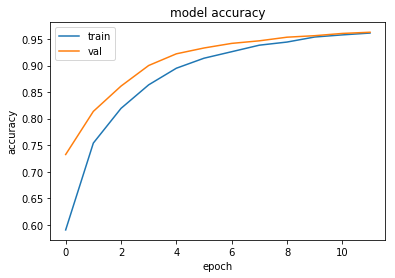

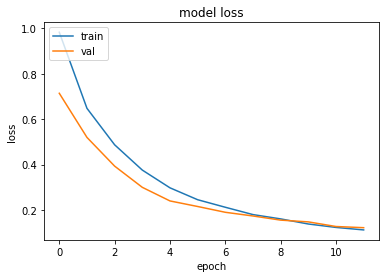

15077/15077 [==============================] - 29s 2ms/step
0.2645274578651304 0.9224646813065998
              precision    recall  f1-score   support

           0       0.99      0.92      0.95     11009
           1       0.64      0.89      0.75       294
           2       0.82      0.95      0.88      2606
           3       0.73      0.91      0.81      1168

    accuracy                           0.92     15077
   macro avg       0.80      0.92      0.85     15077
weighted avg       0.93      0.92      0.93     15077

[[10103   105   501   300]
 [    8   262     4    20]
 [   48    12  2479    67]
 [   34    29    41  1064]]
Train on 48000 samples, validate on 12000 samples
Epoch 1/12
48000/48000 [==============================] - 335s 7ms/step - loss: 0.9917 - acc: 0.5857 - val_loss: 0.7131 - val_acc: 0.7242
Epoch 2/12
48000/48000 [==============================] - 325s 7ms/step - loss: 0.6338 - acc: 0.7562 - val_loss: 0.4741 - val_acc: 0.8243
Epoch 3/12
48000/48000 [========

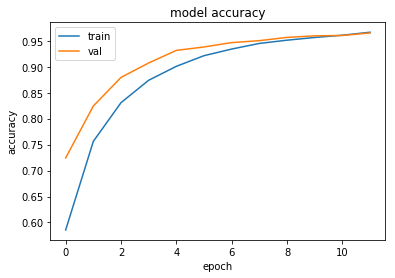

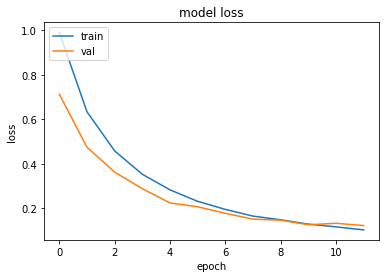

15077/15077 [==============================] - 29s 2ms/step
0.25102340534636786 0.9217350931922534
              precision    recall  f1-score   support

           0       0.99      0.91      0.95     10952
           1       0.62      0.90      0.74       287
           2       0.83      0.95      0.89      2723
           3       0.73      0.93      0.81      1115

    accuracy                           0.92     15077
   macro avg       0.79      0.92      0.85     15077
weighted avg       0.93      0.92      0.92     15077

[[10008   125   504   315]
 [    3   259     5    20]
 [   60    10  2598    55]
 [   30    23    30  1032]]
Train on 48000 samples, validate on 12000 samples
Epoch 1/12
48000/48000 [==============================] - 333s 7ms/step - loss: 0.9826 - acc: 0.5900 - val_loss: 0.6822 - val_acc: 0.7372
Epoch 2/12
48000/48000 [==============================] - 324s 7ms/step - loss: 0.6306 - acc: 0.7594 - val_loss: 0.4701 - val_acc: 0.8266
Epoch 3/12
48000/48000 [=======

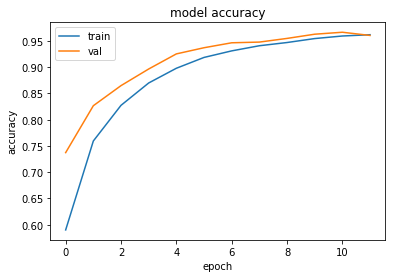

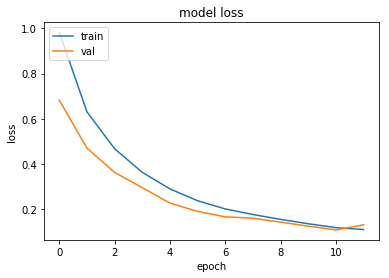

15077/15077 [==============================] - 29s 2ms/step
0.3244452505904499 0.9088014857067056
              precision    recall  f1-score   support

           0       0.99      0.90      0.94     10998
           1       0.62      0.90      0.73       339
           2       0.80      0.94      0.86      2658
           3       0.67      0.91      0.78      1082

    accuracy                           0.91     15077
   macro avg       0.77      0.91      0.83     15077
weighted avg       0.93      0.91      0.91     15077

[[9911  117  602  368]
 [   2  306    4   27]
 [  53   26 2495   84]
 [  18   48   26  990]]
Train on 48000 samples, validate on 12000 samples
Epoch 1/12
48000/48000 [==============================] - 334s 7ms/step - loss: 0.9761 - acc: 0.5928 - val_loss: 0.6974 - val_acc: 0.7349
Epoch 2/12
48000/48000 [==============================] - 325s 7ms/step - loss: 0.6498 - acc: 0.7491 - val_loss: 0.5287 - val_acc: 0.8007
Epoch 3/12
48000/48000 [========================

In [0]:
# run deep learning models for 5 folds of cross validation
stances = ['unrelated', 'disagree', 'discuss', 'agree']
column_names =  ['Headline', 'Body ID', 'Stance', 'articleBody']
all_data = all_data.sample(frac=1).reset_index(drop=True)
accuracy_scores_lstm = []
for i in range(5):
  kFold_train_df = all_data.iloc[0:0]
  kFold_test_df = all_data.iloc[0:0]
  for j in range(4):
    train_fold = dataset_folds(all_data,((i+j)%5)+1,5)
    kFold_train_df = pd.concat([kFold_train_df,train_fold])
  test_fold = dataset_folds(all_data,((i+4)%5)+1,5)
  kFold_test_df = pd.concat([kFold_test_df,test_fold])
  for stance in stances:
    if (len(kFold_train_df[kFold_train_df['Stance'] == str(stance)]) == 0):
      continue;              
    if (len(kFold_train_df[kFold_train_df['Stance'] == str(stance)]) < 15000):
      kFold_train_df = upsample_data(kFold_train_df, str(stance), 15000)
    if (len(kFold_train_df[kFold_train_df['Stance'] == str(stance)]) > 15000):
      kFold_train_df = downsample_data(kFold_train_df, str(stance), 15000)
  t = Tokenizer()
  create_vocabulary(kFold_train_df,t) #create glove vocabulary using test set
  vocabulary_size = len(t.word_index) + 1
  embed_matrix = create_embedding_matrix(embed_index, t) #create embedding matrix
  max_head = max(find_max(kFold_train_df, 'Headline')) #find max length of headline sequences
  model = build_model(vocabulary_size, embed_matrix, max_head, 200, 100, 100) #pass parameters to build model
  encode_train_heads = encode_documents(kFold_train_df, 'Headline', t, max_head) #encode training heads
  encode_train_bodies = encode_documents(kFold_train_df, 'articleBody', t, 200) #encode training bodies
  encode_test_heads = encode_documents(kFold_test_df, 'Headline', t, max_head) #encode test heads
  encode_test_bodies = encode_documents(kFold_test_df, 'articleBody', t, 200) #encode test bodies
  Ytrain = kFold_train_df.Stance.map({'unrelated': 0, 'disagree': 1, 'discuss': 2, 'agree': 3})
  Ytest = kFold_test_df.Stance.map({'unrelated': 0, 'disagree': 1, 'discuss': 2, 'agree': 3})
  nn_score = run_NN(model, encode_train_heads, encode_train_bodies, encode_test_heads, encode_test_bodies, Ytrain, Ytest, kFold_test_df) #train and test deep learning model
  accuracy_scores_lstm.append(nn_score)

In [0]:
from statistics import mean 

print(mean(accuracy_scores_rf))
print(mean(accuracy_scores_mlp))